# **Market Basket Analysis**

This Jupiter Notebook focuses on conducting a Market Basket Analysis (MBA). MBA is a powerful technique employed to uncover associations and relationships between items that are frequently purchased or used together by customers. By understanding these patterns of co-occurrence, retailers can gain valuable insights into customer behavior and preferences, enabling them to optimize their marketing efforts. \
We began by conducting an exploratory data analysis (EDA) on all product-related information. This step provided us with a comprehensive overview of the dataset, highlighting key trends and insights. It served as a foundation for our subsequent analysis, emphasizing the importance of studying customer purchasing behavior and its impact on marketing strategies. \
Building on the refunded analysis, we narrowed our focus to the purchased products within the dataset. Our goal was to identify popular product categories and individual items, which are fundamental for developing effective marketing campaigns and optimizing product placement. \
Additionally, we examined the distribution of customers across purchases. This analysis helped us understand the customer base and purchase patterns, providing insights for tailoring marketing strategies to specific customer segments and optimizing cross-selling opportunities.\
To conduct the Market Basket Analysis, we transformed our data into a transactional dataset. Each row represented an order, and each column represented a specific product. This transformation allowed us to apply the Apriori algorithm, a widely used technique for mining association rules in transactional datasets.\
With the Apriori algorithm, we discovered association rules between sets of products. These rules provide valuable information on the likelihood of co-occurrence between different items in customers' purchases. By identifying products with strong associations, we can develop targeted cross-selling and promotional strategies. \
Armed with the association rules, we can now target specific products for cross-selling promotions. By strategically promoting products frequently purchased together, we can enhance customer engagement, boost sales, and improve the overall customer experience. This data-driven approach enables us to tailor marketing campaigns to customers' preferences and shopping habits.

### **Library set-up and data importation**

To begin our analysis, we need to import the necessary library and loading the data. Our primary fous lies on studying the products, therefore we work mainly with data related to them: `tbl_products.csv` and `tbl_orders.csv`.

In [ ]:
import os
from google.colab import drive
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

In [ ]:
!pip freeze > DSLab_info.txt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
wd = '/content/drive/MyDrive/Troppo noy/Marketing'
os.chdir(wd)

In [ ]:
tbl_products = pd.read_csv('tbl_products.csv')
tbl_orders = pd.read_csv('tbl_orders.csv')

We merge the two tables in order to obtain a single dataframe `df` that contains all the necessary information for analysis:

In [ ]:
df=pd.merge(tbl_orders, tbl_products, on="product_id")
df.head()

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,product_class
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.4,0.00,2022-10-04T182851,6
1,bfe77aedcfc4098926ad5b133cec4a1d,900,18,35551922,1,229.9,22.99,2023-01-08T135407,6
2,0785791dd07b165a9af7729a91c61689,1215,49,35551922,1,41.8,0.00,2022-08-26T195230,6
3,1b3e6d9fcbbe3890c2c0e36a27f49f3b,1351,22,35551922,1,647.9,64.79,2022-09-29T145226,6
4,97f7846be121869a143c060ad5dbdd02,1351,22,35551922,1,62.7,0.00,2022-12-05T085201,6


In [ ]:
df.shape

(1039865, 9)

The dataset contains 1039865 orders with 9 attributes. \
We check for data types and we set the `purchase_datetime`types as `datetime`.

In [ ]:
# Check for datatypes
print(df.dtypes)

order_id              object
customer_id            int64
store_id               int64
product_id             int64
direction              int64
gross_price          float64
price_reduction      float64
purchase_datetime     object
product_class          int64
dtype: object


In [ ]:
# Transform the data format
df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])

### **EDA**

Before proceeding with data preprocessing, it is important to first examine the data to obtain a general overview of the purchasing patterns and characteristics.

**How many orders, products and clients we have?**

In [ ]:
# Number of different orders
tot_orders=df["order_id"].nunique()

# Number  different products
tot_prod=df["product_id"].nunique()

# Number of different clients who made an order
clients=df["customer_id"].nunique()

print(f'Total number of orders = {tot_orders}')
print(f'Total number of products = {tot_prod}')
print(f'Number of distinct clients who made a purchase  = {clients}')


Total number of orders = 371804
Total number of products = 2000
Number of distinct clients who made a purchase  = 104134


#### **Refouded analysis**

Refunds analysis plays a significant role for businesses as it provides valuable insights into customer behavior and purchasing patterns. By analyzing the frequency and reasons behind product returns, companies can improve customer satisfaction, enhancing brand reputation, identify and rectify product quality issues, optimize inventory management and drive product development and innovation.

In our dataset the attribute ` direction` in our dataset identify if the product within the order has been
purchased (1) or refunded (-1).

In this section, our focus shifts towards examining the refunded products to gain insights into their prevalence, identify the most commonly refunded items, and assess their economic impact on the business.

**How many of these orders are purchases and how many are refunds?**

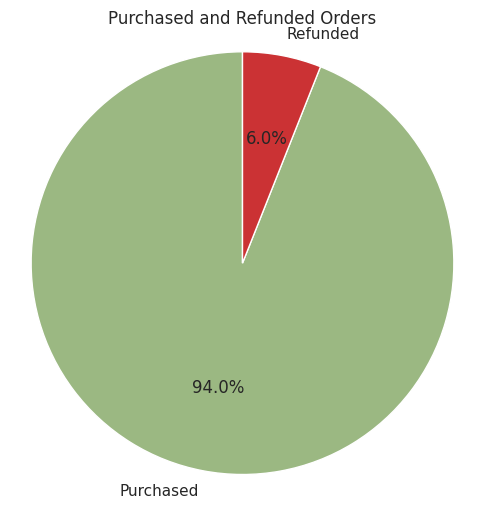

In [ ]:
# Count the number of purchased and refunded orders
order_counts = df['direction'].value_counts()

# Extract the counts and labels for the pie chart
counts = order_counts.values
labels = ['Purchased', 'Refunded']

# Create the pie plot using seaborn
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
sns.set(style="whitegrid")
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90,colors=['#9bb882', '#cb3234'])

# Set the plot title
plt.title('Purchased and Refunded Orders')

# Show the plot
plt.axis('equal')
plt.show()

The 6% of the orders are returned by clients.

**How many clients asked for a refound at least once?**

In [ ]:
num_clients_refunded = df[df['direction'] == -1]['customer_id'].nunique()
print("Number of clients who requested a refund at least once:", num_clients_refunded)
print("Percentage of clients who requested a refund at least once:",round((num_clients_refunded/clients)*100),"%")

Number of clients who requested a refund at least once: 13158
Percentage of clients who requested a refund at least once: 13 %


The 13% of the customers is dissatisfied with their purchases or encounters issues that lead them to request a return.

We investigate whether there are more dissatisfied customers, i.e., customers who have made more than one return:

In [ ]:
customer_refunds = df[df['direction'] == -1].groupby('customer_id').size()
customers_with_multiple_refunds = customer_refunds[customer_refunds > 1]
num_clients_multiple_refunds = len(customers_with_multiple_refunds)
print("Number of clients with more than one refund:", num_clients_multiple_refunds)
print("Percentage of refounded clients with more than one refound:",round((num_clients_multiple_refunds/num_clients_refunded)*100),"%")

Number of clients with more than one refund: 5621
Percentage of refounded clients with more than one refound: 43 %


It is noteworthy that among the clients who requested a refund, 43% of them have returned more than one product.

Let's see who is the customer with the most returns:

In [ ]:
# Clients with the highest number of refunds
max_refunds = customers_with_multiple_refunds.max()
clients_with_max_refunds = customers_with_multiple_refunds[customers_with_multiple_refunds == max_refunds]
client_ids_with_max_refunds = clients_with_max_refunds.index.tolist()

# Product IDs returned by the clients with the highest number of refunds
client_max_refunds_data = df[df['customer_id'].isin(client_ids_with_max_refunds)]
products_returned = client_max_refunds_data[client_max_refunds_data['direction'] == -1]['product_id'].unique()

print(f"The maximum number of refounds requested by a client is: {max_refunds}, asked by client {client_ids_with_max_refunds}")
print("Products returned by the clients with the highest number of refunds:")
print(products_returned)

The maximum number of refounds requested by a client is: 1759, asked by client [447120]
Products returned by the clients with the highest number of refunds:
[31047450 31047464 31047492 31047520 35095970 35074081 35074354 32831085
 30409624 32079082 32078795 31082443 34289171 36554546 31989020 34584102
 31047401 34498282 35609266 34889246 35766080 35662564 36146131 34389250
 31988236 32055310 32055254 31047415 35661703 35827050 31047436 35662515
 34979420 32078872 35662641 32649505 31964954 33794530 35661836 36077083
 31989076 35609350]


The client with the highest number of returns, which is 1759, has caught our attention. We are intrigued by the significant volume of returns made by this client and their consistent purchases of the same articles. We would like to understand the reasons behind such a high number of returns and why he continued buying the same items. Through his unique ID (447120), we can refer to the customer table to gather more information about him. In this way, we can reach out to the client directly to inquire about the issues he may have encountered with his orders and offer assistance in resolving any concerns he may have.

**Which are the most refounded items?**

Then, we investigate the most refounded items. The table below shows for each product the number of time it was purchased and refounded. Then, to understand which articles was most refounded, we calculate the `percentage of refunds` on the total orders for a given product.

In [ ]:
pr_table=df.groupby('product_id')['direction'].value_counts().unstack().fillna(0).astype(int)
pr_table["refound_percentage"]=(pr_table[-1] / (pr_table[1]+pr_table[-1])) * 100
pr_table = pr_table.rename(columns={-1: '# refund', 1: '# purchase'})
pr_table=pr_table.sort_values("refound_percentage",ascending=False).reset_index()

In [ ]:
pr_table.head(10)

direction,product_id,# refund,# purchase,refound_percentage
0,32093992,676,24,96.571429
1,36140146,791,32,96.111786
2,35662515,3492,363,90.583658
3,35805126,229,24,90.513834
4,35143255,508,54,90.391459
5,36074535,290,65,81.690141
6,35074410,203,70,74.358974
7,35662704,1129,495,69.519704
8,35662410,229,112,67.155425
9,35662564,1507,768,66.241758


We see that the first 5 products have a percentage of refound percentage above 90%, suggesting that almost all the customers who have bought these products are not satisfied by them.

**How much do these products cost the business?**

Returned items indeed represent a financial loss for the business. When customers request refunds, the company has to reimburse the amount paid for the returned products, resulting in a reduction of revenue.

In [ ]:
tot_gross_price_ref=df[df["direction"]==-1]["gross_price"].sum()
tot_gross_price = df['gross_price'].sum()
print("Revenues lost to refound customers:",round(tot_gross_price_ref))
print("Percentage of revenues lost to refound customers:", round((tot_gross_price_ref/tot_gross_price)*100),"%")

Revenues lost to refound customers: -1857549
Percentage of revenues lost to refound customers: -7 %


About the 7% of the total annual revenues are used to refound customers, that is about 1857549 euros.

Upon further analysis, we are delving into the specific financial implications of the returns by determining the total profit loss associated with the five products that have the highest return rates.

In [ ]:
worst_product_ids = pr_table['product_id'].head(5)
worst_product=df[df['product_id'].isin(worst_product_ids)]
worst_product_gross=worst_product.groupby('product_id')['gross_price'].sum().reset_index()

In [ ]:
worst_product_gross["gross_price"].sum()

-14309.43

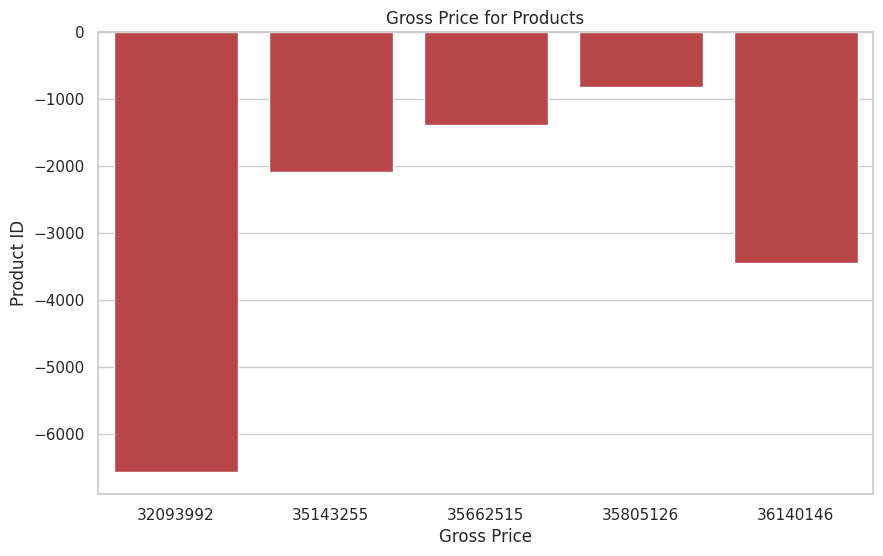

In [ ]:
# Sort the DataFrame by gross_price in ascending order
worst_product_gross = worst_product_gross.sort_values('gross_price')

# Set the plot style
#sns.set_style("whitegrid")

# Create the inverted barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='product_id', y='gross_price', data=worst_product_gross, color='#cb3234')

# Adding labels and title to the plot
plt.xlabel('Gross Price')
plt.ylabel('Product ID')
plt.title('Gross Price for Products')

# Display the plot
plt.show()

The plot above shows that the financial impact for each of the 5 most refounded products. It is evident that the business is incurring losses due to customer dissatisfaction or other factors associated with them: in fact, the sale of these products generate a loss of nearly 15.000 euros. Does it make sense to continue selling them?

> *What can we do?* \
To minimize returns and enhance customer satisfaction, can be implemented several strategies among which we suggest the followings:
* Product evaluation and improvment: investigate the reason behind the high return rates of some products and evaluate the quality, functionality, or any other factors that may contribute to customer dissatisfaction.
* Quality control: ensure that products meet the promised characteristics before putting them in the store or shipping them out.
* Customer feedback and support: encourage customers to provide feedback on their purchase experience and reasons for returns.
* Clear product description and images: ensure that product descriptions and or images accurately represent the product's features, specifications, and appearance.

#### **Purchased analysis**

Moving on, let's shift our attention on the purchased product.


Indeed in market basket analysis (MBA), the focus is typically on the items that have been purchased: our goal is to discover associations and patterns among items that are frequently purchased together.

To ensure the analysis is focused on purchased items, we will filter out the refunded items from the dataset, so that we can get more accurate insights into customer purchasing behavior.

In [ ]:
# Consider only the purchased item
purchased_df = df[(df['direction'] == 1) & (df['gross_price'] >= 0)]
# Drop the direction attribute
purchased_df=purchased_df.drop('direction', axis=1)
purchased_df.shape

(976876, 8)

In [ ]:
# Number of different orders
purchased_df["customer_id"].nunique()

104134

In [ ]:
purchased_df.head()

,order_id,customer_id,store_id,product_id,gross_price,price_reduction,purchase_datetime,product_class
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,125.4,0.00,2022-10-04 18:28:51,6
1,bfe77aedcfc4098926ad5b133cec4a1d,900,18,35551922,229.9,22.99,2023-01-08 13:54:07,6
2,0785791dd07b165a9af7729a91c61689,1215,49,35551922,41.8,0.00,2022-08-26 19:52:30,6
3,1b3e6d9fcbbe3890c2c0e36a27f49f3b,1351,22,35551922,647.9,64.79,2022-09-29 14:52:26,6
4,97f7846be121869a143c060ad5dbdd02,1351,22,35551922,62.7,0.00,2022-12-05 08:52:01,6


**How many customers made more than one order?**

In [ ]:
# Customer with multiple orders
customer_orders = purchased_df.groupby('customer_id')['order_id'].nunique()
multiple_orders = customer_orders[customer_orders > 1]
num_customers_multiple_orders = len(multiple_orders)

print("Number of customers with more than one order:", num_customers_multiple_orders)

Number of customers with more than one order: 70345


**What is the maximum number of orders placed by a customer?**

In [ ]:
print("The maximum number of orders placed by a customer is:",max(customer_orders), "purchased by customer", max(customer_orders.index))

The maximum number of orders placed by a customer is: 49 purchased by customer 934716


Let's visualize more in details the distribution of the number of customers by number of purchases:

In [ ]:
num_customers = [customer_orders[customer_orders >= i].count() for i in range(1, 6)]
df_cum_customers = pd.DataFrame({'Number of Purchases':['1 or more', '2 or more', '3 or more', '4 or more', '5 or more'] , 'Number of Customers': num_customers})
df_cum_customers

,Number of Purchases,Number of Customers
0,1 or more,104134
1,2 or more,70345
2,3 or more,46740
3,4 or more,32790
4,5 or more,23837


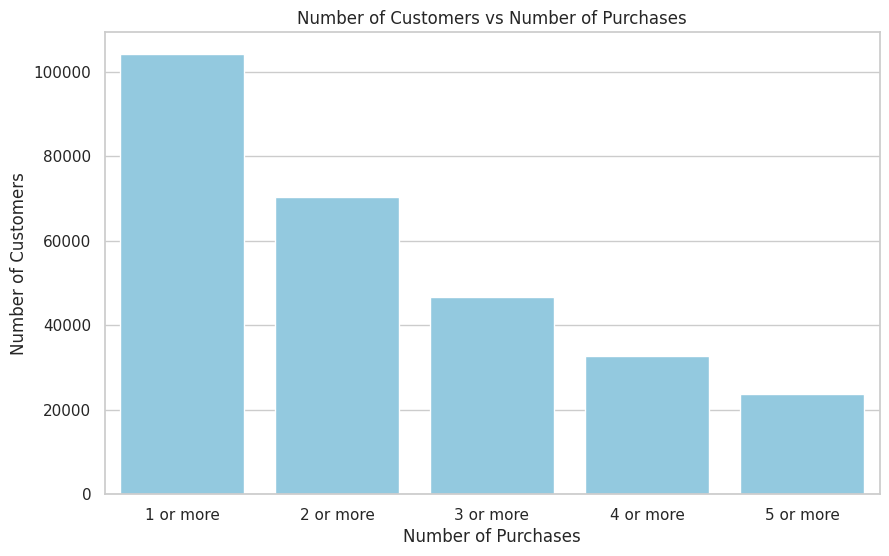

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_cum_customers, x='Number of Purchases', y='Number of Customers', color='skyblue')

# Set labels and title
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.title('Number of Customers vs Number of Purchases')

# Display the plot
plt.show()

From the plot above we can see that a substantial portion of the customer base consists of single-purchase customers. As the number of orders increases, the bars gradually decrease in height, indicating a declining number of clients. This pattern suggests that fewer customers make multiple purchases. The decreasing trend indicates the challenge businesses face in retaining customers and fostering repeat purchases.

**On which days customers make the most purchases?**

In order to plan sales and promotion, understanding the days when customers are most active in making purchases allows businesses to plan their sales and promotional strategies more effectively. They can schedule special offers, discounts, or promotions on those days to maximize customer engagement and drive sales or they can place some promotion on less crowded days  in order to motivate people to avoid peak periods and distribute the shopping traffic more evenly.

In [ ]:
purchased_df['day_of_week'] = purchased_df['purchase_datetime'].dt.dayofweek
days_counts = purchased_df['day_of_week'].value_counts().sort_index()

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_days_counts = pd.DataFrame({'Day of the Week': day_names, 'Purchase Counts': days_counts})
df_days_counts = df_days_counts

df_days_counts

,Day of the Week,Purchase Counts
0,Monday,119749
1,Tuesday,122094
2,Wednesday,135414
3,Thursday,191299
4,Friday,171863
5,Saturday,121760
6,Sunday,114697


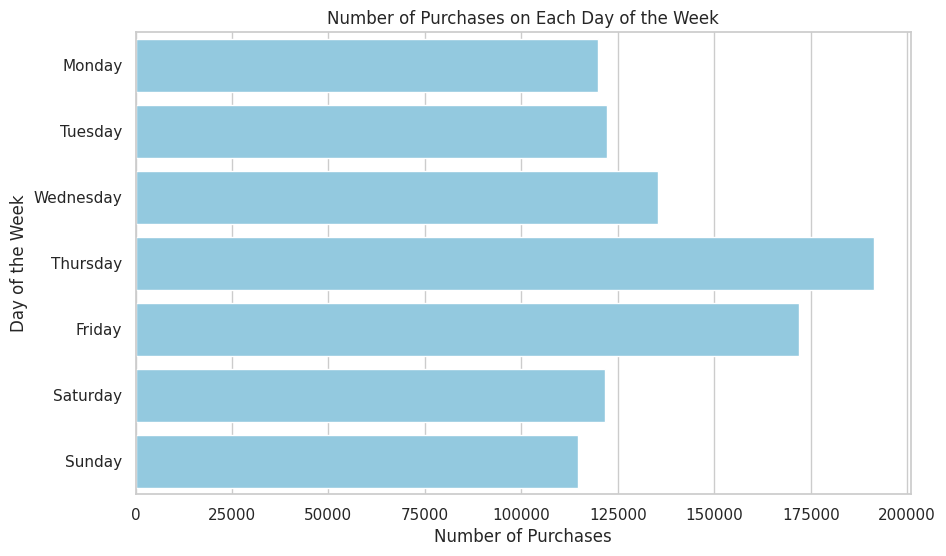

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_days_counts, y='Day of the Week', x='Purchase Counts', color='skyblue')

plt.xlabel('Number of Purchases')
plt.ylabel('Day of the Week')
plt.title('Number of Purchases on Each Day of the Week')

plt.show()

The bar plot illustrates the distribution of purchase counts across different days of the week. \
Thursday stands out as the day with the highest purchase count, with 191,299 transactions. This suggests that Thursday is a particularly busy day for customer purchases, potentially indicating a higher level of consumer activity or promotional incentives offered by the business. Friday follows closely behind, maybe due to the end of the workweek and increased consumer spending habits as people prepare for the weekend. Wednesday also shows a relatively high purchase count, suggesting that midweek is another significant period for customer purchases. Tuesday and Saturday exhibit a moderate level of customer activity, indicating consistent but slightly lower purchasing compared to the aforementioned days. Monday and Sunday have the lowest purchase counts, with 119,749 and 114,697 transactions, respectively. These days may reflect a slightly quieter period for customer purchases, possibly influenced by the beginning and end of the workweek or other factors.

> *What can we do?* \
We can think several strategies to exploit these insight:
* Target promotions: take advantage of the high shopping activity on Thursdays by offering exclusive promotions, discounts or special offers specific to that day. This can incentivize more customers to shop and potentially further increase sales. Moreover, this day represent an opportunity to start weekly promotions: maximizing the exposure to a larger number of consumers, it ensuere a higher visibility of the promotions.
On the other hand, for less crowded Sundays and Mondays, consider offering incentives such as flash sales or limited-time offers to attract more customers during these typically slower periods.
* Off-Peak incentives: incentivize customers to shop on Sundays and Mondays by offering exclusive promotions or discounts during these quieter periods. Encourage customers to take advantage of these off-peak times to avoid the hustle and bustle of busy shopping days.

**At what times of the day do customers make the most purchases?**

We can go deeper into details investigating also the times of the day in which customers make the most purchases. The aims are the same of before.

In [ ]:
df['hour_of_day'] = df['purchase_datetime'].dt.hour
hours_counts = df['hour_of_day'].value_counts().sort_index()

df_hours_counts = pd.DataFrame({'Hour of the Day': hours_counts.index, 'Purchase Counts': hours_counts.values})

df_hours_counts

,Hour of the Day,Purchase Counts
0,6,52
1,7,13362
2,8,22521
3,9,50346
4,10,83172
5,11,103609
6,12,97604
7,13,72914
8,14,68120
9,15,80203


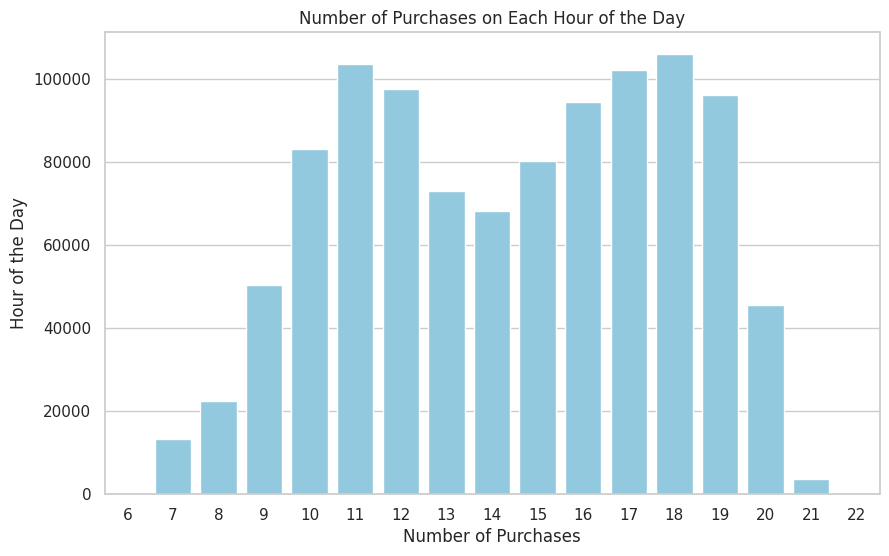

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_hours_counts, y='Purchase Counts', x='Hour of the Day', color='skyblue')

plt.xlabel('Number of Purchases')
plt.ylabel('Hour of the Day')
plt.title('Number of Purchases on Each Hour of the Day')

plt.show()

Here the plot depicts the distribution of purchase counts across different hours of the day. \
The highest purchase counts are observed during the late morning and early afternoon hours. Specifically, between 10 AM and 14, there is a significant surge in customer purchases. The peak occurs around 11, with 103,609 transactions, and remains relatively high until 14, with 97,604 transactions. This indicates that this time period is particularly active for customer engagement and transactions. As the afternoon progresses, the purchase counts gradually decrease, but remain relatively steady until around 18. This suggests that customers continue to make purchases throughout the afternoon, although at slightly lower levels.
During the evening hours, the purchase counts continue to decline. The lowest purchase counts are observed in the late evening and early morning, with the hours between 20 and 6 showing the least customer activity. Notably, there is a significant drop in purchase counts after 9 PM, with a steep decline during the late evening hours.

> We can consider launching discounts on purchases made during early mornings (from opening time until around 8:30) or late evenings (after 20:00).

Now we can focus on the product description:

**Which are the top and the flop products?**

Understanding the purchase counts for different product IDs allows businesses to identify their top-performing products and adapt their strategies accordingly. By focusing on the most popular products, companies can allocate resources, optimize inventory management, and tailor marketing efforts to meet customer demand, ultimately driving sales and enhancing business performance.
We plot the top 10 "sold products":

In [ ]:
product_counts = purchased_df['product_id'].value_counts()

df_product_counts=pd.DataFrame({"Product_id": product_counts.index, "Purchase Counts":product_counts.values}).reset_index(drop=True)

top_10_product=df_product_counts.sort_values("Purchase Counts", ascending=False).head(10)


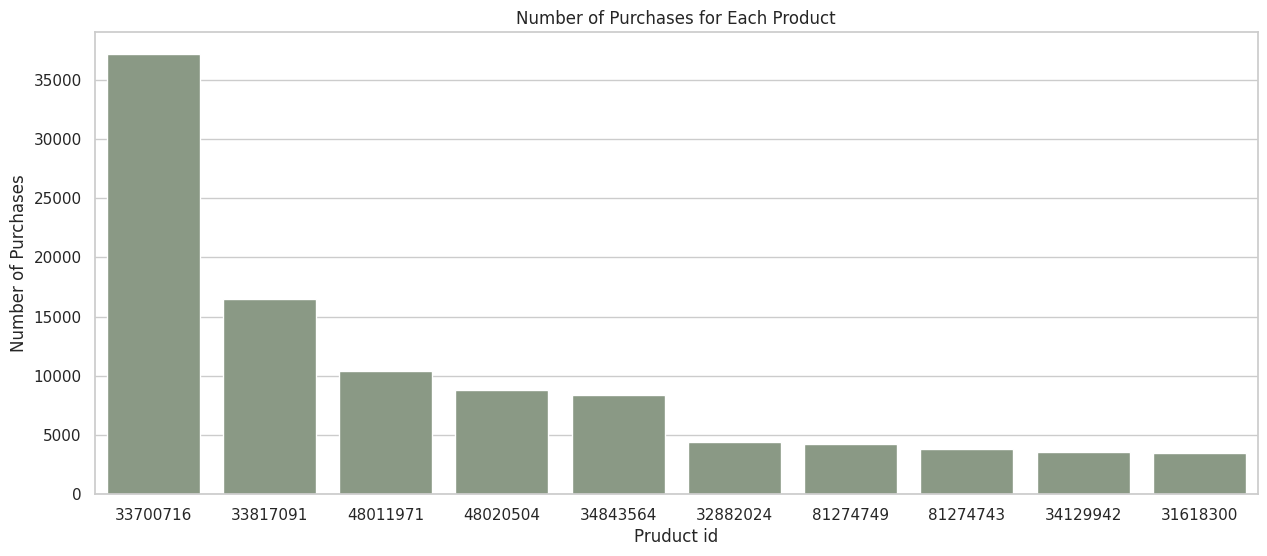

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(data=top_10_product, x='Product_id', y='Purchase Counts', order=top_10_product['Product_id'], color=(0.533,0.611,0.509))

plt.xlabel('Pruduct id')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases for Each Product')

plt.show()

The plot shows the 10 best seller products. \
We can see at a glance that the most purchased item is 33700716, whose absolute frequency is significantly higher than the other products. Next we find the products 33817091, 48011971, 48020504 and 34843564, which can be considered popular among customers. Product IDs 32882024, 81274749, 81274743, 34129942, and 31618300 have relatively lower purchase counts compared to the previously mentioned products. However, they still represent a considerable number of transactions, indicating a level of customer interest in these items.

To which category belongs these product?

In [ ]:
top_10_product_categories = purchased_df[purchased_df['product_id'].isin(top_10_product['Product_id'])].groupby('product_id')['product_class'].first()

print(top_10_product_categories)

product_id
31618300     3
32882024    10
33700716    10
33817091    10
34129942     3
34843564    10
48011971     2
48020504     2
81274743     1
81274749     1
Name: product_class, dtype: int64


We can also check for the 10 least-bought products:

In [ ]:
flop_products=df_product_counts.sort_values("Purchase Counts").head(10)
flop_products

,Product_id,Purchase Counts
1999,35805126,24
1998,32093992,24
1997,36140146,32
1996,35143255,54
1995,36074535,65
1994,35074410,70
1993,35994630,107
1992,36245790,109
1991,35662410,112
1990,35662571,125


There are some products that, approximately in one year, have been bought less than 100 times.

To which category belongs these product?

In [ ]:
flop_10_product_categories = purchased_df[purchased_df['product_id'].isin(flop_products['Product_id'])].groupby('product_id')['product_class'].first()

print(flop_10_product_categories)

product_id
32093992     3
35074410     8
35143255     3
35662410     3
35662571     3
35805126    12
35994630     6
36074535    14
36140146     6
36245790    13
Name: product_class, dtype: int64


> It would be worth investigating the causes of the unpopularity of these products: are they uncommonly used? Are they of poor quality? Are they poorly promoted?

Let's see if these products correspond with the 10 products for which the largest returns are recorded.

In [ ]:
common_product_ids = flop_products[flop_products['Product_id'].isin(pr_table.head(10)['product_id'])]
common_product_ids["Product_id"]

1999    35805126
1998    32093992
1997    36140146
1996    35143255
1995    36074535
1994    35074410
1991    35662410
Name: Product_id, dtype: int64

As expected, 7 out of 10 of the less bought products are the same for which the percentage of returns is higher.

Let's check some insight grouping the products by category. The following table contains various statistical metrics and insights related to different product categories:
* `product_class`: Represents the categories of the products.
* `Number of Products in Cat`: Indicates the number of unique products within each category.
* `Percentage of Products`: Represents the percentage of the number of unique products within each category
* `Percentage of Orders`: Represents the percentage of total orders accounted for by each category.
* `Total Spending`: Represents the total spending on products within each category.
* `Perc of products discounted`: Indicates the percentage of products within each category that were sold with a discount.
* `Perc_tot_gross_by_cat`: Represents the percentage of total gross spending accounted for by each category.


In [ ]:
# Number of products in each category
prod_in_cat=purchased_df.groupby('product_class')['product_id'].nunique()
perc_of_prod=prod_in_cat/prod_in_cat.sum()

# Number of product purchased by category
#prod_purchpurchased_df.groupby('product_class')['order_id'].count()

# Percentage of Orders by Category
total_orders = len(purchased_df)
order_counts_by_cat = purchased_df['product_class'].value_counts()
order_percentages = (order_counts_by_cat / total_orders) * 100

#Spending and discount by category
spending_by_category = purchased_df.groupby('product_class')['gross_price'].sum()
discount_by_category = purchased_df.groupby('product_class')['price_reduction'].sum()

order_discounted_count=(purchased_df[purchased_df["price_reduction"]>0])["product_class"].value_counts()
order_discounted_perc=(order_discounted_count/order_discounted_count.sum())*100

category_stats = pd.DataFrame({
    'Number of Products in Cat': prod_in_cat,
    'Percentage of Products':perc_of_prod,
    'Percentage of Orders': order_percentages,
    'Total Spending': spending_by_category,
    'Perc of products discounted': order_discounted_perc
})

category_stats["Perc_tot_gross_by_cat"]=(category_stats["Total Spending"]/category_stats["Total Spending"].sum())*100

category_stats.reset_index(inplace=True)
category_stats

,index,Number of Products in Cat,Percentage of Products,Percentage of Orders,Total Spending,Perc of products discounted,Perc_tot_gross_by_cat
0,1,55,0.0275,3.294379,586116.87,7.274484,1.983368
1,2,89,0.0445,5.390756,11614223.31,12.732087,39.301518
2,3,552,0.2760,28.798537,2558886.18,29.370083,8.659048
3,4,112,0.0560,5.031754,347936.16,2.337592,1.177386
4,5,38,0.0190,1.452794,242812.62,1.640605,0.821657
5,6,133,0.0665,4.908197,4618423.13,7.682703,15.628341
6,7,207,0.1035,8.514387,3855961.47,9.550612,13.048237
7,8,50,0.0250,1.799614,1206362.84,2.995149,4.082227
8,9,98,0.0490,4.602938,367232.62,3.513926,1.242683
9,10,119,0.0595,11.444851,526874.36,5.623442,1.782897


**Which is the most popular class?**

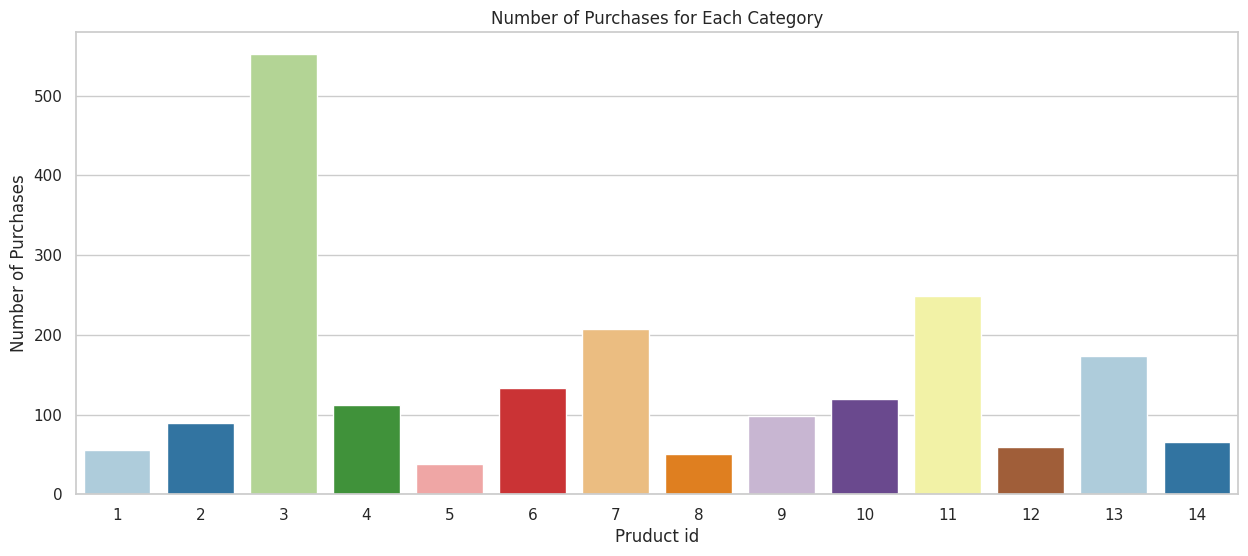

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(data=category_stats, x='index', y='Number of Products in Cat', palette = 'Paired')

plt.xlabel('Pruduct id')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases for Each Category')

plt.show()

Category 3 stand out with a higher number of products: about the 28% of the all products, that is 552 unique products. This indicates a diverse range of offerings within this category, providing customers with a wide selection of choices.

**Which is the best-selling product category?**

In [ ]:
best_selling_cat_row=category_stats.loc[category_stats['Percentage of Orders'].idxmax()]
category_with_highest_percentage = best_selling_cat_row['index']
percentage_of_orders = best_selling_cat_row['Percentage of Orders']

print("Category with the highest percentage of orders:", category_with_highest_percentage, "with a percentage of orders of", round(percentage_of_orders),"%")

Category with the highest percentage of orders: 3.0 with a percentage of orders of 29 %


**Which category brings the most profit to the company?**

In [ ]:
most_profit_cat_row=category_stats.loc[category_stats['Perc_tot_gross_by_cat'].idxmax()]
category_with_highest_profit = most_profit_cat_row['index']
percentage_of_profit = most_profit_cat_row['Perc_tot_gross_by_cat']

print("The category that brings the most profit is:", category_with_highest_profit, "with a percentage of total gross of", round(percentage_of_profit),"%")

The category that brings the most profit is: 2.0 with a percentage of total gross of 39 %


**Which category has the most discount on products?**

In [ ]:
most_discounted_cat_row=category_stats.loc[category_stats['Perc of products discounted'].idxmax()]
category_with_highest_discount = most_discounted_cat_row['index']
percentage_of_discounted = most_discounted_cat_row['Perc of products discounted']

print("The category which has the higher number of products discounted:", category_with_highest_discount, "with a percentage of products discounted of", round(percentage_of_discounted),"%")

The category which has the higher number of products discounted: 3.0 with a percentage of products discounted of 29 %


We investigate more in details the distribution of the average amount of sales by class:

<Figure size 1500x600 with 0 Axes>

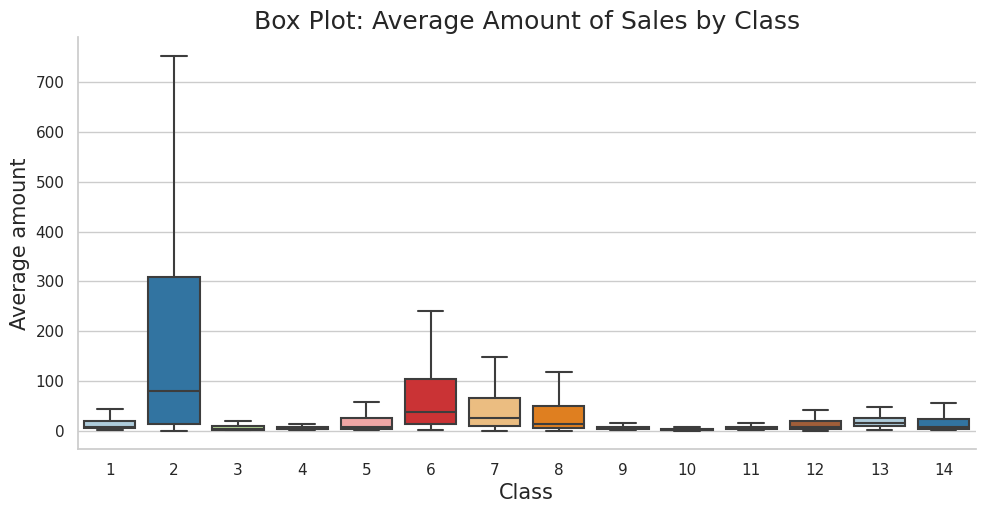

In [ ]:
plt.figure(figsize=(15, 6))
sns.catplot(data = purchased_df, x = "product_class", y = 'gross_price', showfliers = False,palette = 'Paired', aspect = 2, kind = 'box')

plt.title('Box Plot: Average Amount of Sales by Class', fontsize=18)
plt.ylabel('Average amount', fontsize = 15)
plt.xlabel('Class', fontsize = 15)

plt.show()

Interestingly, while category 3 represents the highest percentage of items purchased, it does not generate the highest profit. This can be attributed to the relatively lower prices of items within this category, potentially influenced by the applied discounts. As a result, despite the significant number of products and purchases, the overall profitability of category 3 is not as high.

On the other hand, category 2 emerges as the most profitable category. This can be attributed to the presence of expensive products within this category, including some items with significantly higher prices compared to other categories. The higher price points contribute to greater revenue generation and profitability, even with a comparatively smaller number of products and purchases.

> *What can we do?* \
To maximize the impact of marketing strategies, it's important to focus on the categories with the highest percentage of product purchases and the most profitable categories:
* Targeted promotions: devote your efforts to offering tailored promotions and discounts specifically for the popular and profitable categories. By providing incentives, you can attract more customers and motivate them to make purchases within those categories.
* Cross-selling and upselling: Drive sales by promoting related products or complementary items within the popular and profitable categories. Utilize techniques like product recommendations or bundle deals to encourage customers to explore additional products, thereby increasing their purchase value.
* Product bundling: Create enticing bundle offers by combining products from the popular and profitable categories. This strategy can incentivize customers to buy multiple items together, enhancing their shopping experience and potentially boosting overall sales.
* Enhance product visibility: Optimize the visibility of products within the popular and profitable categories on your website or physical store. Highlight these categories prominently on your homepage, create dedicated sections, or employ eye-catching displays to capture customer attention.

> It is also important to focus on the unpopular and less profitable categories because they present opportunities for growth, differentiation, and customer satisfaction. While popular categories may generate significant revenue, neglecting the less popular ones means missing out on untapped potential and a diverse customer base.
* Market research and analysis: conduct in-depth market research to understand the reasons behind the low popularity and profitability of these categories. Identify potential gaps, customer preferences, or emerging trends that can be leveraged to make these categories more appealing.
* Product optimization: Evaluate the products within these categories and assess if any improvements or modifications can be made to enhance their appeal. This may involve updating product features, packaging, pricing, or positioning to better align with customer needs and market demand.
* Targeted marketing efforts: Develop targeted marketing campaigns to raise awareness and generate interest in the unpopular categories.
* Customer education: focus on educating customers about the value and benefits of the products within the less profitable categories. Provide detailed product information, tutorials, or demonstrations to help customers understand the relevance and usefulness of these products in their lives.
* Product placement and visibility: ensure that products from the less profitable categories are prominently displayed and easily accessible both online and in-store.
* Customer feedback and iteration: seek customer feedback and insights regarding the less profitable categories. Understand their concerns, preferences, and barriers to purchase.

### **Data preprocessing: Market Basket**

In order to perform market basket analysis, it is necessary to transform the dataset into a transactional format. This involves creating a new dataset where each row represents a transaction, and the products purchased within that transaction are listed. \
We achieve this by grouping the products based on the unique `order_id`, as all the products purchased or refunded within the same transaction share the same ID. This resulting dataframe can be seen as the "basket" that customers carry to the cashier, containing the products they have chosen. This transactional format enables us to analyze the associations and patterns among the products that customers tend to purchase together, providing valuable insights for targeted marketing strategies and business decision-making.

In [ ]:
transactional_df = purchased_df.groupby('order_id')['product_id'].apply(list).reset_index(name='products')
transactional_df.head()

,order_id,products
0,000031824fe4f468fc8f68c02e421118,[81273876]
1,00006ee3400d3ae49bed9a904f234500,[34916056]
2,0000901a817e533f4a95d2839c5575a3,"[36238020, 33651121, 35874272]"
3,0000f2817342879fac36a6b9f6a55990,"[35212254, 35160741]"
4,0001231326e40e177b91e3bbe2c85358,"[35874006, 36531131]"


In [ ]:
transactional_df.shape

(353659, 2)

Now, since in MBA we're going to uncover the association between 2 or more items that is bought according to historical data, we are not interested in transaction with only a single item. Hence, we need to filter out the transactions that involve only one item.

In [ ]:
transactional_df1=transactional_df[transactional_df['products'].apply(lambda x: len(x) > 1)]

In [ ]:
transactional_df1.shape

(196592, 2)

The shape of the `transactional_df1` reveals that there are 196592 transactions where multiple items were purchased. This indicates that over half (55.5%) of the basket data consists of transactions that involve the purchase of more than one item.

Finally, to prepare our data we need to encode the basket data into a binary data that shows whether an items is bought (`1 or True`) or not (`0 or False`).

In [ ]:
# Convert the list of products in each transaction to a transactional list
transaction_list = transactional_df1['products'].tolist()

# Encode the transactional list
te = TransactionEncoder()
te_array = te.fit(transaction_list).transform(transaction_list)

# Create a new DataFrame with the encoded transactional data
df_encoded = pd.DataFrame(te_array, columns=te.columns_).set_index(transactional_df1['order_id'])
df_encoded.head()

,504553,30033521,30044455,30062452,30072014,30097186,30097291,30097340,30099454,30126292,...,82019008,82026198,82026199,82029521,82029522,82040488,82042962,82042965,82042968,82042974
order_id,,,,,,,,,,,,,,,,,,,,,
0000901a817e533f4a95d2839c5575a3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0000f2817342879fac36a6b9f6a55990,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0001231326e40e177b91e3bbe2c85358,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
00022115c5638382d758a0d7dd9ee0a1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
000268e2f8e3612058d55568fa884b9e,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The final dataset, `df_encoded`, is structured in a way that each transaction is represented as a row, with the `order_id` serving as the index label for easy identification. Each column in the dataset indicates the presence or absence of a specific product within a transaction. This binary encoding allows us to capture the composition of each transaction in terms of the products purchased.

### **Market Basket Analysis**

Now we're ready to apply the apriori algorithm, the most common technique for performing market basket analysis. It is used for association rule mining, which is a rule-based process used to identify correlations between items purchased by users. \
The Apriori algorithm has three main components:
* $Support(Item)=\frac{Transactions \ comprising \ the \ item }{Total \ transaction}$. \
It assess the overall popularity of a given product (a high support value indicates that the item is present in most purchases, therefore marketers should focus on it more).
* $Confidence(Item1 →Item2)=\frac{Transactions \ comprising \ item1 \ and \ item2}{Transactions \ comprising \ item1}$ \
It tells us the likelihood of different purchase combinations, that is how many users who purchased Item1 also bought Item2.
* $Lift=\frac{Confidence(Item1 →Item2)}{Support(Item1)}$.\
It refers to the increase in the ratio of the sale of item2 when you sell item1.

In [ ]:
# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True).sort_values("support",ascending=False).reset_index(drop=True)
frequent_itemsets['lenght'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,lenght
0,0.155561,(33700716),1
1,0.070669,(33817091),1
2,0.036258,(34843564),1
3,0.019085,(32882024),1
4,0.014426,(34252904),1
...,...,...,...
98,0.005127,(36218140),1
99,0.005077,(33801586),1
100,0.005041,(35929054),1
101,0.005010,(33995213),1


The results of the `apriori` algorithm provide valuable insights into the frequent itemsets discovered in the dataset: each itemset represents a unique combination of items that occur frequently in customer transactions. The `lenght` attribute indicates the number of items in each itemset.

The itemset are defined on the basis of their popularity, i.e. the support. Since we have many products and only few of them differ greatly in frequency of purchase, we set a support threshold of `0.005`, which means that an itemset is frequently bought if it appears in at least `0.5%` of all transactions.

The itemset displayed in the output are sorted in descending order of support. Thus, the most frequent itemset includes just the article `33700716` which appears in approximately 15.6% of the total transactions in the dataset. As we're already seen in the EDA it is the top selling product.


The itemset `(33700716)` is the least frequent itemset and falls just above the threshold value.



Once the frequent itemsets are discovered, we generate the association rules. Association rules represent relationships between items and are defined by metrics such as support, confidence, and lift. They provide valuable insights and knowledge about which items are more likely to be sold together, allowing us to extract information and identify effective product combinations.

By setting the metric parameter to `lift `in the association_rules function, we prioritize the discovery and evaluation of association rules based on their lift values. This approach enables us to identify meaningful and potentially profitable relationships between products in the dataset.

In [ ]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift").sort_values("lift",axis = 0, ascending = False).reset_index(drop=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(36298353),(36298381),0.007223,0.006282,0.005422,0.750704,119.499956,0.005377,3.986100
1,(36298381),(36298353),0.006282,0.007223,0.005422,0.863158,119.499956,0.005377,7.254908
2,"(32079082, 32842551)",(32079103),0.005804,0.014044,0.005275,0.908852,64.713151,0.005193,10.817072
3,(32079103),"(32079082, 32842551)",0.014044,0.005804,0.005275,0.375589,64.713151,0.005193,1.592213
4,"(32078795, 32079103)",(32079082),0.006959,0.013347,0.005911,0.849415,63.638809,0.005818,6.552139
5,(32079082),"(32078795, 32079103)",0.013347,0.006959,0.005911,0.442835,63.638809,0.005818,1.782312
6,"(32079082, 32079103)",(32078795),0.009599,0.009772,0.005911,0.615792,63.019174,0.005817,2.577326
7,(32078795),"(32079082, 32079103)",0.009772,0.009599,0.005911,0.604893,63.019174,0.005817,2.506668
8,"(32079082, 32078795)",(32079103),0.006735,0.014044,0.005911,0.877644,62.491015,0.005816,8.058058
9,(32079103),"(32079082, 32078795)",0.014044,0.006735,0.005911,0.420862,62.491015,0.005816,1.715075


From the `association_rules` results we got 49 rules. We further filter the rules setting  a minimum threshold for the confidence level to focus on more significant and reliable associations.
Since we want to  find unexpected relations in the purchase patterns of our product we define a threshold of 0.65, so that we are able to capture both strong and reliable associations and potential associations (even if weaker) between products.

In [ ]:
filtered_rules = rules[rules['confidence'] >= 0.65].reset_index(drop=True)
filtered_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(36298353),(36298381),0.007223,0.006282,0.005422,0.750704,119.499956,0.005377,3.986100
1,(36298381),(36298353),0.006282,0.007223,0.005422,0.863158,119.499956,0.005377,7.254908
2,"(32079082, 32842551)",(32079103),0.005804,0.014044,0.005275,0.908852,64.713151,0.005193,10.817072
3,"(32078795, 32079103)",(32079082),0.006959,0.013347,0.005911,0.849415,63.638809,0.005818,6.552139
4,"(32079082, 32078795)",(32079103),0.006735,0.014044,0.005911,0.877644,62.491015,0.005816,8.058058
5,"(32079082, 32078935)",(32079103),0.007401,0.014044,0.006272,0.847423,60.339196,0.006168,6.462007
6,"(32079103, 32842551)",(32079082),0.006918,0.013347,0.005275,0.762500,57.127058,0.005183,4.154327
7,"(32078935, 32079103)",(32079082),0.008342,0.013347,0.006272,0.751829,56.327599,0.006161,3.975701
8,(32078795),(32079082),0.009772,0.013347,0.006735,0.689224,51.637194,0.006604,3.174807
9,"(32079082, 32079103)",(32078935),0.009599,0.012757,0.006272,0.653418,51.218810,0.006149,2.848512


We are left with **15 rules**. These rules are sorted by creascent lift values. A lift value greater than 1 indicates a positive association, where the antecedent and consequent are more likely to occur together. In this dataset, we observe high lift values where the majority of them ranges from 50.71 to 64.71. The first two rules deviate strongly, taking on a very high value (119.5).

However, it is important to note that the support values for these rules range from 0.005275 to 0.009599, indicating that these rules are present in a relatively small portion of the transactions. Although the lift values are high, it is essential to consider the overall occurrence frequency of these rules. The relatively low support values suggest that these associations are specific to a subset of transactions rather than being universally prevalent.

Then, we have to check for reduntant rules, and, if so, eliminate them:

In [ ]:
redundant_rules = []

for i, rule in filtered_rules.iterrows():
    lhs = rule['antecedents']
    rhs = rule['consequents']
    confidence = rule['confidence']

    for j, other_rule in filtered_rules.iloc[i+1:].iterrows():
        other_lhs = other_rule['antecedents']
        other_rhs = other_rule['consequents']
        other_confidence = other_rule['confidence']

        if rhs == other_rhs and set(lhs).issubset(set(other_lhs)) and confidence <= other_confidence:
            redundant_rules.append(i)
            break

redundant_rules



[]

We don't have rules which have the same RHS and less items in the LHS with the same o a lower confidence level.

To better visualize our association rules, we display them using a `scatterplot` and a `network graph`:

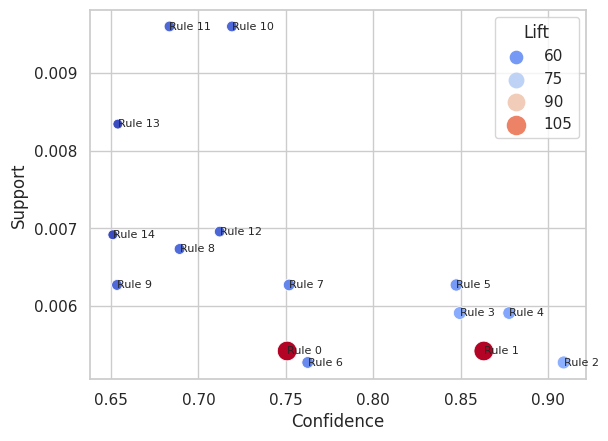

In [ ]:
ax = sns.scatterplot(
    x="confidence",
    y="support",
    size="lift",
    data=filtered_rules,
    sizes=(50, 200),
    hue='lift',
    palette="coolwarm"
)

plt.ylabel('Support', fontsize=12)
plt.xlabel('Confidence', fontsize=12)

legend = ax.legend(markerscale=1)
legend.set_title('Lift')

for index, row in filtered_rules.iterrows():
    antecedents = row['antecedents']
    consequents = row['consequents']
    label = f"Rule {index}"
    ax.text(row['confidence'], row['support'], label, fontsize=8, verticalalignment='center')

plt.show()

In addition to the information provided earlier, we can further analyze the relationship between support and confidence using a scatterplot. By plotting the support and confidence values for the generated rules, we can visually assess if there is a clear trend or correlation between these two metrics. However, upon examining the scatterplot, we observe that there is no distinct pattern or conclusive relationship between support and confidence. The data points appear to be scattered without a clear trend or consistent correlation between the two metrics.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


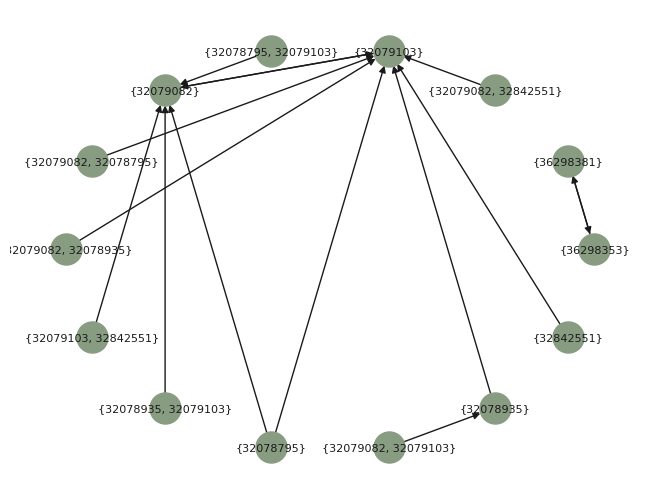

In [ ]:
# Create the directed graph
G = nx.from_pandas_edgelist(filtered_rules, 'antecedents', 'consequents', create_using=nx.DiGraph())

new_labels = {}

# New labels
for node in G.nodes:
    label = str(node).replace('frozenset', '').replace('(', '').replace(')', '')
    new_labels[node] = label

pos = nx.circular_layout(G)

nx.draw(G, pos, labels=new_labels, with_labels=True, node_size=500,font_size=8, node_color=(0.533,0.611,0.509), arrows=True)

The network diagram provides a visual representation of the association rules, showing the antecedents and consequents as nodes connected by directed edges. The arrows indicate the direction of the relationship between the items. This graph can help in understanding the relationships and patterns among the items and their associations based on the generated rules.

We notice the presence of two connected components in the graph. One of these components consists of only two products, namely 36298381 and 36298353. These two products are related only to each other, indicating a specific association or pattern between them. This isolated component may represent a unique relationship.

Additionaly, we can observe that the product 32079103 appears to be a popular consequent, as it has multiple antecedents connected to it. This suggests that there are several itemsets that often lead to the purchase or occurrence of product 32079103.

Now, let's investigate and interpret the rules.

Looking at the first two rules (`Rule 0` and `Rule 1`) we note that they have the same products as antecedent and consequents in reversed order, suggesting a very strong association between the items. Thus, we check for other symmetric rules:

In [ ]:
switched_rows_df = pd.DataFrame(columns=filtered_rules.columns)

for index, row in filtered_rules.iterrows():
    antecedents = row['antecedents']
    consequents = row['consequents']

    # Check if there is a row with reversed antecedents and consequents
    reversed_row = filtered_rules[(filtered_rules['antecedents'] == consequents) & (filtered_rules['consequents'] == antecedents)]

    # Create a dataframe with rows with reversed antecedents and consequents
    if not reversed_row.empty:
      switched_rows_df = switched_rows_df.append(row)

switched_rows_df

<ipython-input-55-6683f1e9c10f>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  switched_rows_df = switched_rows_df.append(row)
<ipython-input-55-6683f1e9c10f>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  switched_rows_df = switched_rows_df.append(row)
<ipython-input-55-6683f1e9c10f>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  switched_rows_df = switched_rows_df.append(row)
<ipython-input-55-6683f1e9c10f>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  switched_rows_df = switched_rows_df.append(row)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(36298353),(36298381),0.007223,0.006282,0.005422,0.750704,119.499956,0.005377,3.986100
1,(36298381),(36298353),0.006282,0.007223,0.005422,0.863158,119.499956,0.005377,7.254908
10,(32079082),(32079103),0.013347,0.014044,0.009599,0.719131,51.204426,0.009411,3.510377
11,(32079103),(32079082),0.014044,0.013347,0.009599,0.683448,51.204426,0.009411,3.116874


We find another symmetric rule couple. Both rules shows high lift values, which means that the 2 pair of products (36298353-36298381 and 32079082-32079103) are very good to be sold together. In this situation we can think of two possibilities:
* Selecting the rule with an higher confidence value, that is selecting just the rule 1 and the rule 10. For example, we see that the confidence of `rule 1`(0.86) is much higher than the confidence of `rule 0` (0.75). *This means that a customer who buys product 36298381, is more likely to also buy product 36298353, than vice versa.*
* Taking into account the two rules. For example `rule 10` and `rule 11` show closer values of confidence, that is: there is a 71.9131% chance that when product 32079082 is present in a transaction, product 32079103 will also be present and there is a 68.34% of chance that if a customer buy product 32079103 he will also buy product 32079082. So, there is not a higher difference in the direction of the implication of the rule which govern the relation between these two items.


**Which articles appear in the rules?**

In [ ]:
# Extract unique articles from antecedents
antecedents = filtered_rules['antecedents'].explode().unique()

# Extract unique articles from consequents
consequents = filtered_rules['consequents'].explode().unique()

# Create a single list of unique articles from the rules
articles_in_rules = list(set().union(antecedents, consequents))

print("In the 15 rules appear the following",len(articles_in_rules),"articles:",articles_in_rules)

In the 15 rules appear the following 7 articles: [32079082, 32078795, 36298381, 36298353, 32078935, 32842551, 32079103]


We filter the `purchased_df` selecting only the rows concerning the articles in the rules. We store these information in `interesting_articles` dataframe.

In [ ]:
interesting_articles = purchased_df[purchased_df['product_id'].isin(articles_in_rules)]
interesting_articles.reset_index(inplace = True, drop = True)
interesting_articles

,order_id,customer_id,store_id,product_id,gross_price,price_reduction,purchase_datetime,product_class,day_of_week
0,2a06b2b44cab2bce985bdb920c73fa13,194,49,36298353,18.91,0.01,2023-04-25 18:43:48,3,1
1,c8794f3f0690dec8d3355067bdb4a41f,231,28,36298353,21.01,0.01,2022-07-14 10:18:10,3,3
2,61972f7bd3093187f9495740b106a4cc,481,10,36298353,43.02,4.02,2022-11-10 13:11:14,3,3
3,43121a9c11968d6d34ca73a4742ae70b,552,26,36298353,39.02,0.02,2022-12-27 17:15:07,3,1
4,52868029f3370a44bff1c557535886a6,956,44,36298353,21.01,0.01,2022-07-06 11:40:37,3,2
...,...,...,...,...,...,...,...,...,...
17357,18821a98af2c304720bd6eb662e998bc,924035,44,32079103,0.90,0.00,2023-04-24 10:49:19,3,0
17358,7ebb4a8e1b34e491f08196833b9974d9,925168,33,32079103,19.80,0.00,2023-04-25 11:46:05,3,1
17359,7ebb4a8e1b34e491f08196833b9974d9,925168,33,32079103,19.80,0.00,2023-04-25 11:46:05,3,1
17360,6280a305b7788af7164de90d743ca8b5,925923,37,32079103,4.50,0.00,2023-04-25 16:26:51,3,1


**To which class these articles belong?**

In [ ]:
interesting_articles["product_class"].unique()

array([3])

All the items comprising the most relevant itemsets belong to the category 3. We've already seen that the category 3 is the most popular one. The insights derived from the rules can serve as a valuable resource for implementing effective cross-selling strategies and targeted promotions for products within this category.

**How many customers bought these combinations of products and who are them?**



Understanding the number of customers who bought specific combinations of products and identifying their identities enables effective customer segmentation, allowing for tailored marketing strategies and personalized experiences. It also presents cross-selling opportunities, as businesses can recommend complementary products to customers based on their purchase history.

In the following code snippet, we build a table `combination_orders` where, for each product combination appearing in the rules, we report the number of customers who have purchased it and save a list of their IDs.

In [ ]:
combinations_set = set()

for _, row in filtered_rules.iterrows():
    antecedents = list(row['antecedents'])

    antecedents.sort()
    comb_tuple = tuple(antecedents)

    combinations_set.add(comb_tuple)

combinations_list = list(combinations_set)

In [ ]:
combinations_list

[(36298353,),
 (32079082,),
 (32079103, 32842551),
 (32079082, 32842551),
 (32078795, 32079103),
 (36298381,),
 (32078935, 32079103),
 (32078795,),
 (32079082, 32079103),
 (32842551,),
 (32079103,),
 (32078795, 32079082),
 (32078935,),
 (32078935, 32079082)]

In [ ]:
combination_orders = pd.DataFrame(columns=['combination', 'client_count', 'client_list','order_count','order_list'])

for combination in combinations_list:

    # Filter the dataframe by products of the combination
    filtered_df = interesting_articles[interesting_articles['product_id'].isin(combination)]

    # Grouping by order_id and counts od the unique products in each order
    order_counts = filtered_df.groupby('order_id')['product_id'].nunique()

    # Filter the result keeping just the orders which have the lenght of the combination
    filtered_orders = order_counts[order_counts >= len(combination)]

    # Client_id extraction
    if not filtered_orders.empty:
        valid_order_ids = filtered_orders.index.tolist()
        client_list = interesting_articles[interesting_articles['order_id'].isin(valid_order_ids)]['customer_id'].unique().tolist()

        order_list = filtered_orders.index.unique().tolist()

        # Result
        combination_orders = combination_orders.append({
            'combination': combination,
            'client_count': len(client_list),
            'client_list': client_list,
            'order_count': len(filtered_orders),
            'order_list':order_list

        }, ignore_index=True)

combination_orders


<ipython-input-97-1310dd009eaf>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combination_orders = combination_orders.append({
<ipython-input-97-1310dd009eaf>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combination_orders = combination_orders.append({
<ipython-input-97-1310dd009eaf>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combination_orders = combination_orders.append({
<ipython-input-97-1310dd009eaf>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combination_orders = combination_orders.append({
<ipython-input-97-1310dd009eaf>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas

,combination,client_count,client_list,order_count,order_list
0,"(36298353,)",1265,"[194, 231, 481, 552, 956, 1055, 1080, 1351, 15...",1441,"[0011482e8480a062b688fbe64006a643, 00468822679..."
1,"(32079082,)",2022,"[194, 27095, 28525, 46563, 55599, 67005, 68771...",2669,"[000cc930859065024ff325cba25ce2bf, 0027be32692..."
2,"(32079103, 32842551)",1122,"[28525, 46563, 55599, 68771, 75837, 81410, 903...",1360,"[00802e53053cc27f2c5e38bf52c7d481, 00e56c1a078..."
3,"(32079082, 32842551)",956,"[28525, 46563, 55599, 68771, 75837, 81410, 921...",1141,"[008a42ccf5ff1679721e4ff5e154834e, 00e56c1a078..."
4,"(32078795, 32079103)",1171,"[27095, 28525, 46563, 67005, 69773, 81410, 912...",1368,"[0027be32692ac16182c8b6f00a1b725f, 00e56c1a078..."
5,"(36298381,)",1114,"[194, 231, 481, 552, 956, 1055, 1351, 2344, 27...",1254,"[0046882267974258150a5e87ee3bbde2, 00469923028..."
6,"(32078935, 32079103)",1349,"[27095, 46563, 54268, 55599, 67005, 68771, 697...",1640,"[0027be32692ac16182c8b6f00a1b725f, 006576dcc7a..."
7,"(32078795,)",1612,"[13385, 27095, 28525, 46563, 62353, 67005, 697...",1967,"[0027be32692ac16182c8b6f00a1b725f, 00bebc2d6cb..."
8,"(32079082, 32079103)",1519,"[27095, 28525, 46563, 55599, 67005, 68771, 697...",1887,"[0027be32692ac16182c8b6f00a1b725f, 006547a58f8..."
9,"(32842551,)",1723,"[28525, 46563, 55599, 68771, 75837, 81410, 903...",2176,"[00802e53053cc27f2c5e38bf52c7d481, 008114d2b80..."


**Which are, on average, the most profitable associations?**

Checking for the profitability of association rules is useful in evaluating their economic returns and aiding decision-making processes regarding promotional strategies. Understanding the economic returns of association rules enables businesses to prioritize and focus on those that generate higher profits, ensuring that marketing initiatives and promotions are strategically directed towards maximizing revenue. \
In the table `combination_profit` we calculate the average net profit (gross price + price reduction) for each association rules. We return the `antecedents` average net price (which is calculated as the sum of the average net price of the antecedents element in the combination), the `consequent` average net price and the `total average net` price.

In [ ]:
interesting_articles["net_price"]=interesting_articles["gross_price"]+interesting_articles["price_reduction"]

# Calculate the average net price for each product
avg_net_price = interesting_articles.groupby('product_id')['net_price'].mean().reset_index()

# Function to calculate the average price for a single product
def calculate_avg_price(product):
    return avg_net_price.loc[avg_net_price['product_id'] == product, 'net_price'].iloc[0]

# Function to calculate the average price for multiple products
def calculate_avg_price_multiple(products):
    return sum([calculate_avg_price(product) for product in products])

# Calculate average price of antecedents
antecedent_avg_prices = filtered_rules['antecedents'].apply(calculate_avg_price_multiple)

# Calculate average price of consequents
consequent_avg_prices = filtered_rules['consequents'].apply(calculate_avg_price_multiple)

# Create a new dataframe with the calculated average prices
combination_profit = pd.DataFrame({
    'Antecedents': filtered_rules['antecedents'],
    'Consequent': filtered_rules['consequents'],
    'Antecedent_Avg_Price': antecedent_avg_prices,
    'Consequent_Avg_Price': consequent_avg_prices,
})

# Calculate the total average price
combination_profit["Tot_avg_price"] = combination_profit['Antecedent_Avg_Price'] + combination_profit['Consequent_Avg_Price']

combination_profit.sort_values("Tot_avg_price", ascending=False)

<ipython-input-61-64e2842962af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interesting_articles["net_price"]=interesting_articles["gross_price"]+interesting_articles["price_reduction"]


,Antecedents,Consequent,Antecedent_Avg_Price,Consequent_Avg_Price,Tot_avg_price
0,(36298353),(36298381),25.826377,25.127350,50.953728
1,(36298381),(36298353),25.127350,25.826377,50.953728
7,"(32078935, 32079103)",(32079082),22.888579,6.833673,29.722253
9,"(32079082, 32079103)",(32078935),12.574219,17.148034,29.722253
5,"(32079082, 32078935)",(32079103),23.981707,5.740546,29.722253
2,"(32079082, 32842551)",(32079103),17.500224,5.740546,23.240770
6,"(32079103, 32842551)",(32079082),16.407096,6.833673,23.240770
13,(32078935),(32079103),17.148034,5.740546,22.888579
3,"(32078795, 32079103)",(32079082),12.356778,6.833673,19.190451
4,"(32079082, 32078795)",(32079103),13.449905,5.740546,19.190451


The results are presented in ascending order, indicating that the most profitable combination of products is (36298381) and (36298353). Based on the association rules table, we can infer that if a customer purchases product 36298381, there is a high likelihood that they will also purchase product 36298353. This association between the two products is particularly valuable as it significantly increases the profitability. Instead of a profit of 25 euros, which is the net price of product 36298381, the inclusion of product 36298353 results in a gain of approximately 50 euros. This highlights the importance of leveraging these association rules to drive additional revenue and maximize profitability by strategically promoting and cross-selling related products.

**Which are the key product?**

Finally we identify the key product, which are products that exclusively appear either as antecedents or as consequents in the association rules.

Key products that only appear as antecedents signify strong influencing factors or drivers of customer purchasing behavior.

Focusing on these key products helps streamline the promotional efforts by reducing the number of products to be actively promoted. By identifying and prioritizing these key products within the association rules, businesses can trigger a series of reactions in other product combinations.

In [ ]:
filtered_rules2=filtered_rules.drop(index=0)

In [ ]:
all_antecedents = set()
all_consequents = set()

for row in filtered_rules2['antecedents']:
    all_antecedents.update(row)

for row in filtered_rules2['consequents']:
    all_consequents.update(row)

# Trova i prodotti che compaiono solo come antecedenti
antecedents_only = all_antecedents - all_consequents

# Stampa i risultati
print("Products that exclusively appear as antecedent:")
for product in antecedents_only:
    print(product)

Products that exclusively appear as antecedent:
32078795
36298381
32842551


In [ ]:
key_product_list = list(antecedents_only)

influencing_products = {}
influenced_products = {}

# Estrai i prodotti influenzanti e influenzati per ciascun prodotto di interesse
for product in key_product_list:
    influenced = list(set(filtered_rules2[filtered_rules2['antecedents'].apply(lambda x: product in x)]['consequents'].explode()))
    influenced_products[product] = influenced

# Stampa i risultati
for product in key_product_list:
    print(f"Products influenced by {product}:")
    print(influenced_products[product])
    print()

Products influenced by 32078795:
[32079082, 32079103]

Products influenced by 36298381:
[36298353]

Products influenced by 32842551:
[32079082, 32079103]



### **Interpretation of results**

In conclusion, by analyzing the most frequent itemsets in customer shopping carts and extracting the significant product association rules, we have successfully identified a select few products to prioritize in our marketing strategy.

In fact, upon analyzing the market basket data, we observe an interesting association between product 36298381 and product 36298353. These two products exclusively appear together in a rule, indicating a strong dependence between them. This is evident in the graph representation, where these two products form a connected component. Notably, this association exhibits the highest linkage with a lift value and a confidence of 86 percent. Additionally, it generates the highest average net profit as both products individually have a price of approximately 25 euros, resulting in a combined profit of about 50 euros.

Exploiting the dependency between these two products becomes crucial for maximizing profits. One strategy is to apply a discount, such as 10%, on item 36298381, making it more appealing to customers and consequently increasing the likelihood of them also purchasing item 36298353. This discount can be part of a targeted marketing campaign specifically targeting customers who have previously purchased item 36298381.

Another strategy is to strategically position these items near each other on store shelves or within the online site. This spatial proximity can enhance the visibility and accessibility of both products, making it easier for customers to consider purchasing them together.

Furthermore, recommendations systems can be employed to suggest the purchase of item 36298353 when a customer selects or purchases item 36298381. Whether through algorithm in online platforms or by instructing store clerks, personalized recommendations can guide customers towards exploring and purchasing both products.

Considering the other two key products, in the stronger association they are involved, appears the same 4 products: 32079082, 32842551, 32078795, and 32079103. We can devise a promotion strategy called "Mix and Match." This promotion encourages customers to combine these four items by offering a special discount when customers choose any combination of 2 of these products together.

By exploiting the cross-selling potential of product 32079103, we should recommend its purchase whenever the product combinations (32079082, 32842551) and (32079082, 32078795) are bought.

Among the associations, the rule (32079082, 32842551) -> (32079103) stands out with a high confidence value of approximately 91%. This suggests that whenever customers purchase products 32079082 and 32842551 together, they are highly likely to add product 32079103 to their shopping cart. To capitalize on this association, we can create a box set containing products 32079082 and 32842551 at a discounted price. This bundled offering provides an attractive proposition for customers who already intend to purchase both products together. By promoting the box set, we can increase overall sales and attract customers who seek a convenient and cost-effective option to acquire both products simultaneously. As a result, the sales of all three products will likely see a boost.

### **Targeted campain: integration with RFM results**

In this section we use the results of  RFM segmentation and Market Basket Analysis to  tailor our marketing strategies to send targeted promotions to specific customer segments.

With RFM segmentation, we have categorized our clients in 7 class based on their recency, frequency, and monetary value scores, allowing us to understand their engagement and overall value to our business.

During our market basket analysis, we recorded the order IDs associated with clients who purchased specific combinations of products identified through product association rules. This enables us to retrieve detailed data about individual clients.

By combining the insights from RFM segmentation and market basket analysis, we can create targeted promotions that align with the interests of specific customer segments.

In [ ]:
rfm_results=pd.read_csv("df_rfm.csv")
customers_table=pd.read_csv("tbl_customers.csv")

**Which customers we should inform about promotions?**

**Promotion on 36298381**

As discussed earlier, our primary objective is to boost sales of the product associated with the rule, 36298381, and subsequently drive sales of product 36298353. To achieve this, we will personalize the promotion of the product based on each customer's RFM category.

Initially, we will focus on customers who have previously purchased product 36298381. We will analyze their RFM categories to understand their engagement and value. To facilitate this, we will create a dictionary where we will track the count of customers belonging to each RFM category who have made at least one purchase of product 36298381. Additionally, we will maintain a list of their customer IDs. Thought these informations it will be possible to access detailed customer information and contact them via email or SMS.

In [ ]:
clients_8381=combination_orders[combination_orders["combination"]==(36298381,)]["client_list"].iloc[0]
RFM_8381=rfm_results[rfm_results['customer_id'].isin(clients_8381)]

rfm_levels = RFM_8381['RFM_Level'].unique()
customer_8381_lists = {}

for rfm_level in rfm_levels:
    customers = RFM_8381[RFM_8381['RFM_Level'] == rfm_level]['customer_id'].tolist()
    count = len(customers)
    customer_8381_lists[rfm_level] = {'customers': customers, 'count': count}

# Stampa dei valori nel dizionario
for rfm_level, data in customer_8381_lists.items():
    customers = data['customers']
    count = data['count']
    print(f"Quantity of '{rfm_level}' clients: {count}")
    print(f"Customers for '{rfm_level}': {customers}")

Quantity of 'Gold' clients: 507
Customers for 'Gold': [194, 231, 481, 1055, 1351, 2344, 4010, 5014, 8108, 9416, 10868, 12067, 14161, 14206, 14241, 15360, 20500, 21576, 21660, 21780, 23064, 23602, 26030, 27168, 27906, 27982, 28019, 31925, 32073, 32605, 32750, 34922, 36103, 36184, 37932, 41931, 42043, 42646, 46035, 47665, 48880, 54268, 55319, 55543, 55599, 55968, 57936, 58742, 60067, 62363, 63984, 65000, 66266, 68124, 68645, 68860, 70342, 72438, 73753, 76195, 76872, 80236, 81696, 82331, 88851, 88868, 89645, 89883, 90306, 91239, 91943, 93591, 94879, 95343, 97321, 99057, 99395, 100158, 101482, 103555, 105481, 108579, 111388, 118028, 125859, 133711, 135628, 136008, 136510, 138774, 139538, 141801, 147331, 149402, 153674, 157390, 159101, 161431, 161619, 163549, 166953, 173656, 174006, 175987, 176257, 176855, 180386, 183129, 184127, 186903, 188051, 191605, 192192, 198763, 203547, 204144, 204187, 206459, 206572, 212344, 213598, 219507, 222717, 230161, 232017, 232063, 233097, 234880, 236066, 236

The majority of customers who have previously purchased product 36298381 belong to the esteemed Gold and Diamond category, signifying their high value to our company. Given their frequent visits and significant spending (reflected in high frequency, recency, and medium to high monetary values), it is crucial to provide them with personalized care. We can seize this opportunity by sending tailored messages that promote product 36298353, enlightening its characteristics and explaining how it could be used in combination with product 36298381. \
Moreover, we can also propose, if there is one, a premium version or upgraded model of the product being promoted, applying a percentage discount on the first purchase. \
To express our gratitude for their loyalty and the contributions they have made, we can introduce a special promotion called "Celebrate with Us!" Specifically, during their birthday month, for every order placed, we can offer them a complimentary gift of product 36298381. This gesture serves as a token of appreciation, enhancing their customer experience and reinforcing their connection with our brand. By acknowledging their importance and providing personalized rewards, we foster customer loyalty and long-term relationships with these valuable customers.

For our Silver and Bronze customers, we can devise a promotion that incentivizes their next purchase. Specifically, if they repurchase product 36298381, we can offer them a coupon as a reward. This promotion encourages repeat purchases of the same product, further engaging these customers and fostering their loyalty. By providing an additional incentive, we not only drive sales but also create a sense of anticipation and excitement for their future interactions with our brand.

To foster loyalty within the Copper category, we can implement time-limited discounts that make product 36298381 more affordable and enticing. By offering these exclusive discounts, we aim to incentivize Copper customers to visit our store within a specified timeframe.

These limited-time discounts create a sense of urgency and encourage Copper customers to take advantage of the special pricing. By highlighting the affordability and attractiveness of the product during this promotional period, we can capture their attention and increase their likelihood of making a purchase.

Additionally, while the Tin and Cheap categories consist of a smaller customer base and may not bring significant immediate value, it's important to maintain a positive customer experience and provide opportunities for potential future growth. Although specific promotions may not be activated for these categories at the moment, it's crucial to continue engaging with them through general marketing efforts and ensuring their satisfaction with our products and services.

By continuously evaluating and analyzing customer response and behavior across all categories, we can adjust our strategies and tailor future promotions to optimize customer engagement and drive sales.



**Promotion on 32079082 and 32842551**

We repeat the process for the combination of products 32079082 and 32842551.

In [ ]:
clients_9082_2551=combination_orders[combination_orders["combination"]==(32079082,32842551)]["client_list"].iloc[0]
RFM_9082_2551=rfm_results[rfm_results['customer_id'].isin(clients_9082_2551)]

rfm_levels = RFM_9082_2551['RFM_Level'].unique()
customer_9082_2551_lists = {}

for rfm_level in rfm_levels:
    customers = RFM_9082_2551[RFM_9082_2551['RFM_Level'] == rfm_level]['customer_id'].tolist()
    count = len(customers)
    customer_9082_2551_lists[rfm_level] = {'customers': customers, 'count': count}

# Stampa dei valori nel dizionario
for rfm_level, data in customer_9082_2551_lists.items():
    customers = data['customers']
    count = data['count']
    print(f"Quantity of '{rfm_level}' clients: {count}")
    print(f"Customers for '{rfm_level}': {customers}")

Quantity of 'Diamond' clients: 324
Customers for 'Diamond': [989, 5695, 6892, 7380, 9957, 17896, 20330, 20624, 24939, 28525, 28692, 31553, 31837, 32359, 38517, 41443, 46353, 46563, 47503, 51682, 53631, 58796, 61077, 62353, 66089, 68157, 68771, 68785, 70732, 71503, 75837, 76770, 78166, 81184, 81721, 84942, 88122, 88270, 89456, 92190, 97658, 100279, 101595, 105806, 116596, 139334, 145275, 149943, 157615, 158139, 165507, 165812, 170814, 170844, 171086, 177664, 177683, 185705, 185714, 189466, 192257, 192638, 194755, 195098, 198243, 203614, 203750, 209733, 210562, 210811, 212184, 219669, 220189, 221346, 229944, 240596, 243458, 246089, 247484, 248541, 258790, 269210, 271017, 271656, 272958, 277470, 280451, 289054, 289274, 289790, 292753, 295162, 296678, 298896, 302581, 303054, 303267, 305176, 305849, 306299, 306374, 308497, 310168, 311953, 312164, 313212, 317832, 318869, 319330, 323944, 325070, 325225, 325800, 326233, 326251, 328281, 329826, 332058, 334357, 336307, 336960, 340750, 341197, 34

We are delighted to observe that the distribution of our client base remains consistent, with diamonds and gold being the most prevalent classes. This indicates that customers who opt for this combination of products are loyal patrons who contribute significantly to our revenue. Building upon the promotions mentioned earlier, we have devised an additional offering.

For our esteemed platinum and gold customers, we have prepared an exclusive package that includes both the diamond and gold products, along with a complimentary sample of our product 32079103. By presenting them with this special package, not only do we enhance their inclination to make a purchase, but we also provide an opportunity for customers who haven't tried the 32079103 item to experience it firsthand. This trial can potentially convince them to consider future purchases of this product.

In the case of our silver customers, we would like to introduce the "Advantageous Combo," featuring a remarkable 20% discount on the set. This enticing offer is designed to increase their likelihood of making a purchase, enticing them with a cost-effective deal that combines both products.

Lastly, for our esteemed bronze and copper customers, we have devised an appealing strategy to incentivize future purchases. In addition to offering a discount on the set, we are pleased to provide them with free shipping on their next two online orders. This added benefit of free shipping encourages these customers to continue their online shopping experience, making their next two purchases even more convenient and cost-effective.